In [8]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from app_import.NEOs import NEOs, load_neos

# Load API Key from .env file
load_dotenv()
NASA_API_KEY = os.getenv('NASA_API_KEY')

# List of asteroid IDs (NEOs) you are interested in
neolist = ['2020 CW', '2020 JJ', '2020 QG', '2020 VT4', '2021 SP', '2021 UA1', 
           '2022 FD1', '2022 GQ5', '2022 KP6', '2022 SK4', '2022 UR4', '2023 AV', 
           '2023 BU', '2023 RS', '2023 UR10', '2024 GJ2', '2024 HA', '2024 LH1', 
           '2024 UZ6', '2024 UG9', '2024 XA', '2025 BP6']

class NasaAPINEOClient:
    API_ENDPOINT = "https://api.nasa.gov/neo/rest/v1/neo/"

    def __init__(self, api_key):
        self.api_key = api_key
        self.data = []

    def fetch_neo_details(self, asteroid_id):
        """
        Fetch details of a specific NEO by its asteroid ID.
        """
        response = requests.get(f"{self.API_ENDPOINT}{asteroid_id}", params={'api_key': self.api_key})
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {asteroid_id}: {response.status_code}")
            return None

    def get_selected_neo_details(self):
        """
        Fetch detailed data for only the NEOs in the 'neolist'.
        """
        for asteroid_id in neolist:
            details = self.fetch_neo_details(asteroid_id)
            if details:
                for approach in details["close_approach_data"]:
                    self.data.append({

                        "name": details["name"],
                        "is_potentially_hazardous": details.get("is_potentially_hazardous_asteroid"),
                        "is_sentry_object": details.get("is_sentry_object"),
                        "diameter_min_meters": details["estimated_diameter"]["meters"]["estimated_diameter_min"],
                        "diameter_max_meters": details["estimated_diameter"]["meters"]["estimated_diameter_max"],
                        "close_approach_date": approach["close_approach_date"],
                        "relative_velocity_km_h": approach["relative_velocity"]["kilometers_per_hour"],
                        "miss_distance_km": approach["miss_distance"]["kilometers"],
                        "orbiting_body": approach["orbiting_body"],
                        "first_observation_date": details["orbital_data"].get("first_observation_date"),
                        "last_observation_date": details["orbital_data"].get("last_observation_date"),
                        "observations_used": details["orbital_data"].get("observations_used"),
                        "orbit_uncertainty": details["orbital_data"].get("orbit_uncertainty"),
                        "minimum_orbit_intersection": details["orbital_data"].get("minimum_orbit_intersection"),
                        "inclination": details["orbital_data"].get("inclination"),
                        "orbital_period": details["orbital_data"].get("orbital_period")
                    })

        return pd.DataFrame(self.data)

if __name__ == "__main__":
    client = NasaAPINEOClient(NASA_API_KEY)
    df = client.get_selected_neo_details()

In [9]:
# Convert columns to appropriate numerical types
df['relative_velocity_km_h'] = pd.to_numeric(df['relative_velocity_km_h'], errors='coerce')
df['miss_distance_km'] = pd.to_numeric(df['miss_distance_km'], errors='coerce')
df['orbit_uncertainty'] = pd.to_numeric(df['orbit_uncertainty'], errors='coerce')
df['minimum_orbit_intersection'] = pd.to_numeric(df['minimum_orbit_intersection'], errors='coerce')
df['inclination'] = pd.to_numeric(df['inclination'], errors='coerce')
df['orbital_period'] = pd.to_numeric(df['orbital_period'], errors='coerce')

# Perform the groupby operation
grouped_df = df.groupby('name').agg({
    'is_potentially_hazardous': 'first',
    'is_sentry_object': 'first',
    'diameter_min_meters': 'mean',
    'diameter_max_meters': 'mean',
    'close_approach_date': 'count',  # Count the number of close approaches
    'relative_velocity_km_h': 'mean',
    'miss_distance_km': 'mean',
    'orbiting_body': lambda x: ', '.join(set(x)),  # Combine unique orbiting bodies
    'first_observation_date': 'first',
    'last_observation_date': 'first',
    'observations_used': 'sum',
    'orbit_uncertainty': 'first',
    'minimum_orbit_intersection': 'first',
    'inclination': 'first',
    'orbital_period': 'first'
}).rename(columns={'close_approach_date': 'close_approach_count'})

print(grouped_df)

             is_potentially_hazardous  is_sentry_object  diameter_min_meters  \
name                                                                           
(2020 CW)                       False              True             0.817627   
(2020 JJ)                       False             False             2.783268   
(2020 QG)                       False             False             2.783268   
(2020 VT4)                      False             False             5.041444   
(2021 SP)                       False             False             3.737274   
(2021 UA1)                      False              True             1.139082   
(2022 FD1)                      False             False             1.638910   
(2022 GQ5)                      False             False             1.209358   
(2022 KP6)                      False             False             3.487827   
(2022 SK4)                      False             False             2.262325   
(2022 UR4)                      False   

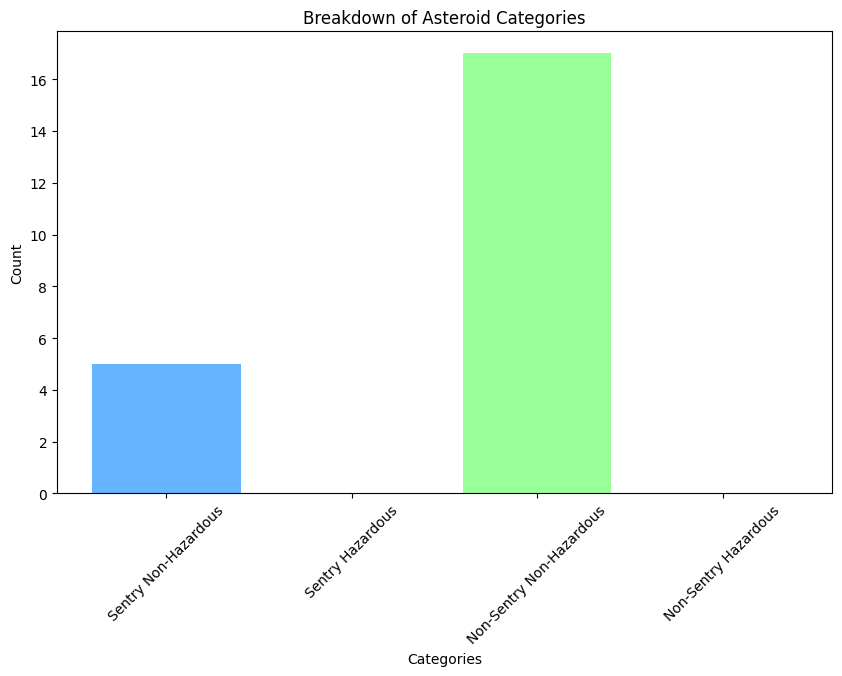

In [10]:
# Calculate the counts for each category
sentry_non_hazardous = len(grouped_df[grouped_df['is_sentry_object'] & ~grouped_df['is_potentially_hazardous']])
sentry_hazardous = len(grouped_df[grouped_df['is_sentry_object'] & grouped_df['is_potentially_hazardous']])
non_sentry_non_hazardous = len(grouped_df[~grouped_df['is_sentry_object'] & ~grouped_df['is_potentially_hazardous']])
non_sentry_hazardous = len(grouped_df[~grouped_df['is_sentry_object'] & grouped_df['is_potentially_hazardous']])

# Data for the bar chart
categories = ['Sentry Non-Hazardous', 'Sentry Hazardous', 'Non-Sentry Non-Hazardous', 'Non-Sentry Hazardous']
counts = [sentry_non_hazardous, sentry_hazardous, non_sentry_non_hazardous, non_sentry_hazardous]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Breakdown of Asteroid Categories')
plt.xticks(rotation=45)
plt.show()

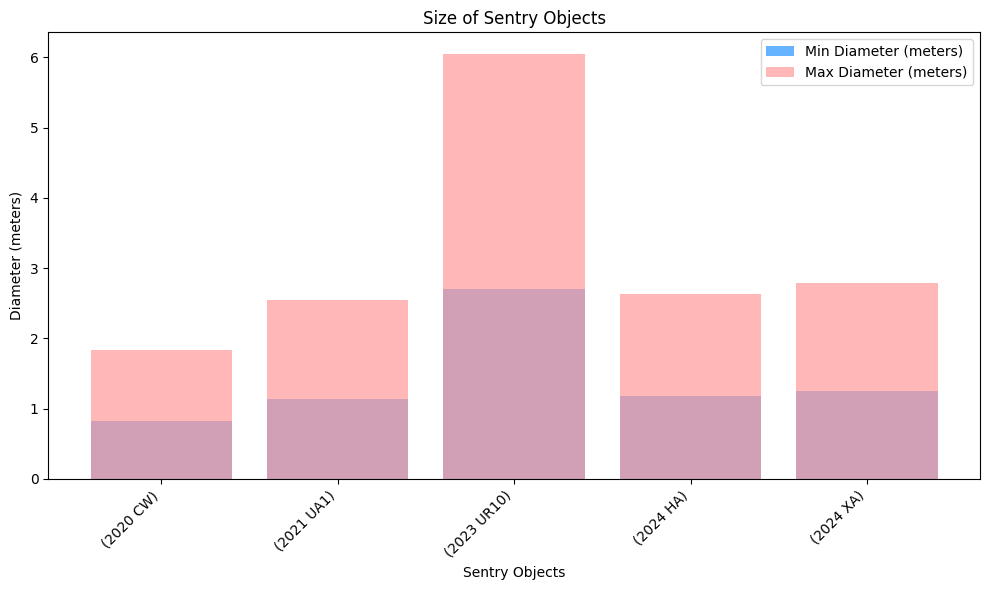

In [11]:
# Filter the grouped_df DataFrame to include only sentry objects
sentry_objects = grouped_df[grouped_df['is_sentry_object']]

# Plot the size of sentry objects
plt.figure(figsize=(10, 6))
plt.bar(sentry_objects.index, sentry_objects['diameter_min_meters'], label='Min Diameter (meters)', color='#66b3ff')
plt.bar(sentry_objects.index, sentry_objects['diameter_max_meters'], label='Max Diameter (meters)', color='#ff9999', alpha=0.7)

plt.xlabel('Sentry Objects')
plt.ylabel('Diameter (meters)')
plt.title('Size of Sentry Objects')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
import plotly.express as px

# Create an interactive bar chart
fig = px.bar(
    grouped_df.reset_index(),
    x='name',
    y=['diameter_min_meters', 'diameter_max_meters'],
    title='Average Diameter of Asteroids',
    labels={'value': 'Diameter (meters)', 'name': 'Asteroid Name'},
    barmode='group'
)

# Customize the layout
fig.update_layout(
    xaxis_title="Asteroid Name",
    yaxis_title="Diameter (meters)",
    legend_title="Diameter Type",
    xaxis_tickangle=45
)

# Show the plot
fig.show()

In [14]:
neos= load_neos(1e-6, -4, 0)

for neo in neos:
    neo.get_data_and_summary()

AttributeError: 'NEOs' object has no attribute 'get_data_and_summary'